## Setup

In [1]:
import deeptrack as DT
import imageGeneration as IG
import benchmark
import unet
import cv2
import numpy as np

In [2]:
#bugfix for fredrik REMOVE LATER
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], False)

## Generate images using our method

In [3]:
import os
import glob

def get_image_parameters_preconfig(image_size=256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    #particle_number = randint(2, 5)
    particle_number = 0
    particle_radius_list = uniform(5, 10, particle_number)
    (particle_center_x_list, particle_center_y_list) = IG.generate_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.3, 0.5, 1), ])

    image_parameters = IG.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.2, .5),
        signal_to_noise_ratio=lambda: uniform(5,100),
        gradient_intensity=lambda: uniform(0, 0.1),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters


get_image_parameters_function=lambda: get_image_parameters_preconfig(image_size = 51)


batch_images,batch_labels,batch_predictions, particle_positions_and_radiuses = IG.get_batch(get_image_parameters_function = get_image_parameters_function,batch_size=10, include_particle_positions_radii_and_intensities = True) 
number_of_images_to_save = 10


files = glob.glob('./images/*')
for f in files:
    os.remove(f)
        
for image_number,image in enumerate(batch_images):
    if image_number>=number_of_images_to_save:
        break
    
    filepath = './images/frame{}.jpg'.format(str(image_number))
    image = image*255
    cv2.imwrite(filepath,image)

cv2.destroyAllWindows()

Time taken for batch generation of size 10: 0.06385946273803711 s.


### Construct video from images


In [4]:
benchmark.construct_video_from_images(number_of_images_to_save)


## Tracking and visualisation using deeptrack


In [8]:
saved_network_file_name = "DeepTrack - Example 1a - Pretrained network.h5"
dt_model = DT.load(saved_network_file_name)

video = cv2.VideoCapture("output.mp4")
(number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
 boxes_all) = DT.track_video("output.mp4", dt_model,box_half_size = 18,box_scanning_step = 3,frame_normalize = 0,frame_enhance = 1,number_frames_to_be_tracked = 0)


In [9]:
print(predicted_positions_wrt_frame)

[[[[18.23211366 17.89362224  2.85593194]
   [18.23211366 20.89362224  2.85593194]
   [18.23211366 23.89362224  2.85593194]
   [18.23211366 26.89362224  2.85593194]
   [18.23211366 29.89362224  2.85593194]]

  [[21.23349932 17.89370009  2.85617012]
   [21.23194431 20.89333994  2.85553873]
   [21.2320054  23.8934418   2.85568035]
   [21.23213595 26.89351794  2.85596949]
   [21.23211366 29.89362224  2.85593194]]

  [[24.23478088 17.89377203  2.8563906 ]
   [24.23187957 20.8932318   2.85538852]
   [24.23192755 23.89331191  2.8555001 ]
   [24.23216318 26.89339063  2.85601455]
   [24.2321381  29.8935079   2.85597271]]

  [[27.23187444 17.89421865  2.85459566]
   [27.23237068 20.8927921   2.85565621]
   [27.23232337 23.89294478  2.85570717]
   [27.23286766 26.89368061  2.85610199]
   [27.23263149 29.89366229  2.85604835]]

  [[30.23201569 17.89386619  2.85538584]
   [30.23211366 20.89362224  2.85593194]
   [30.232115   23.89361803  2.85593033]
   [30.23248907 26.89365134  2.8560167 ]
   [30.2

particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
particle_radial_distance_threshold too small, no predictions passed
-1
-1


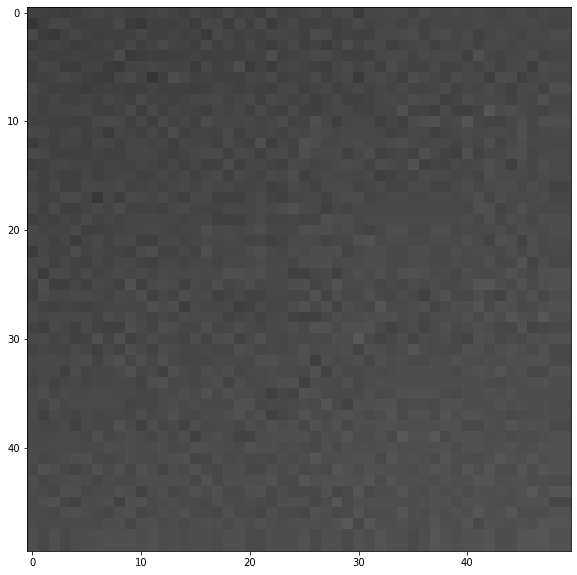

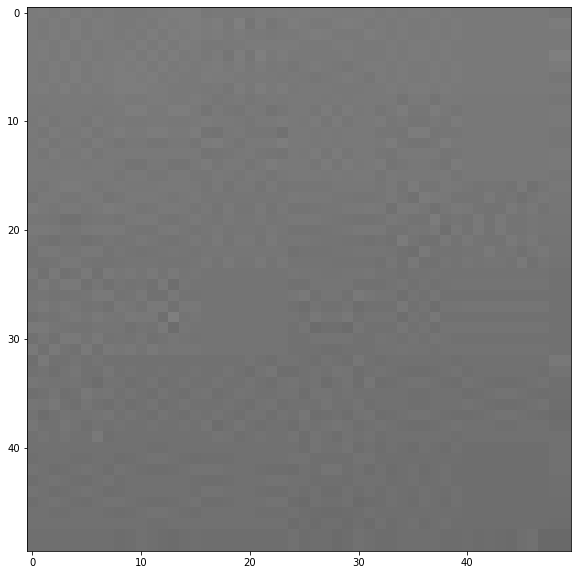

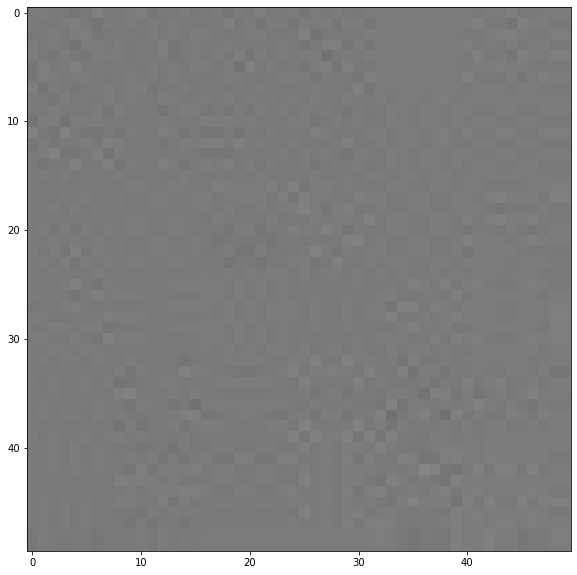

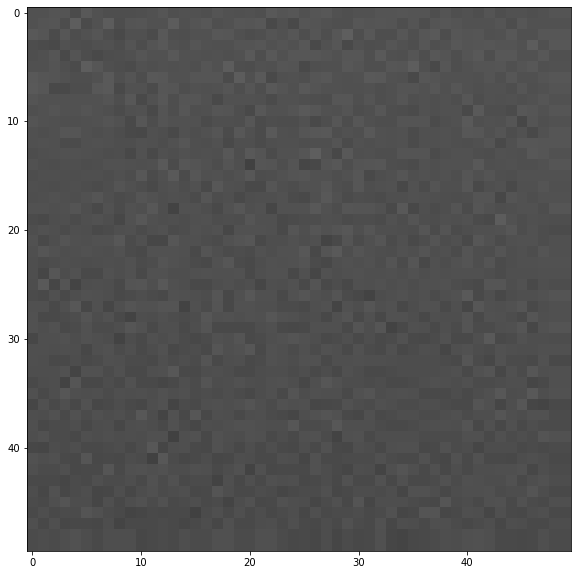

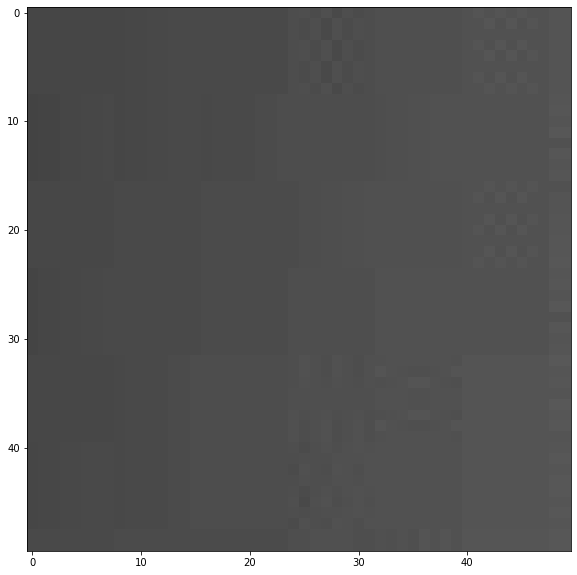

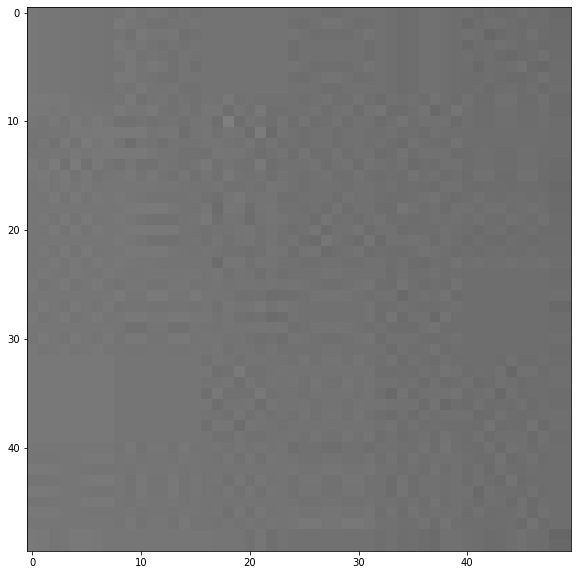

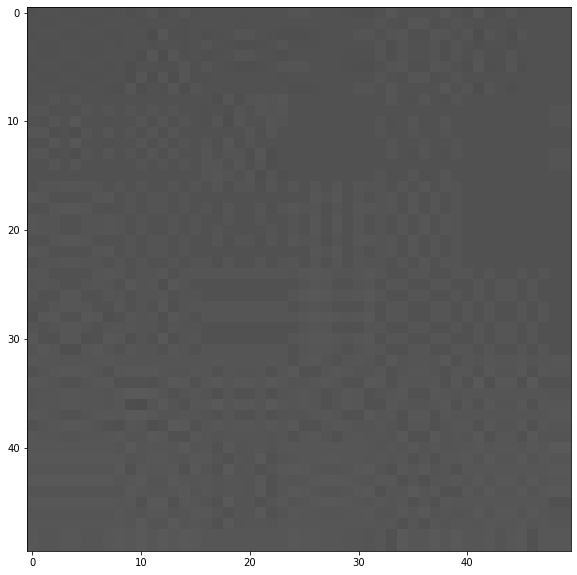

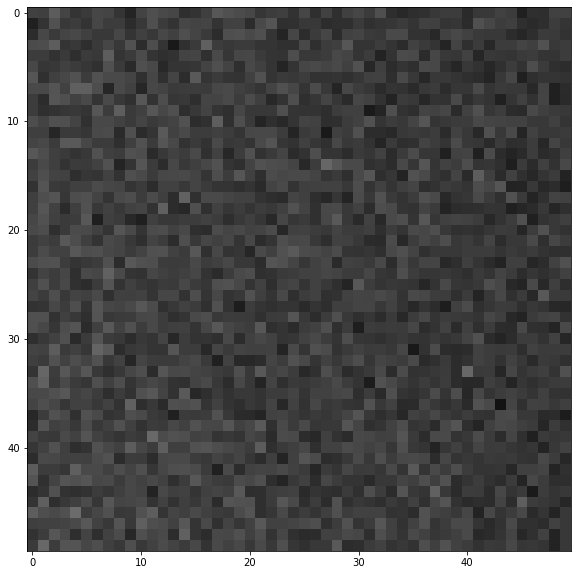

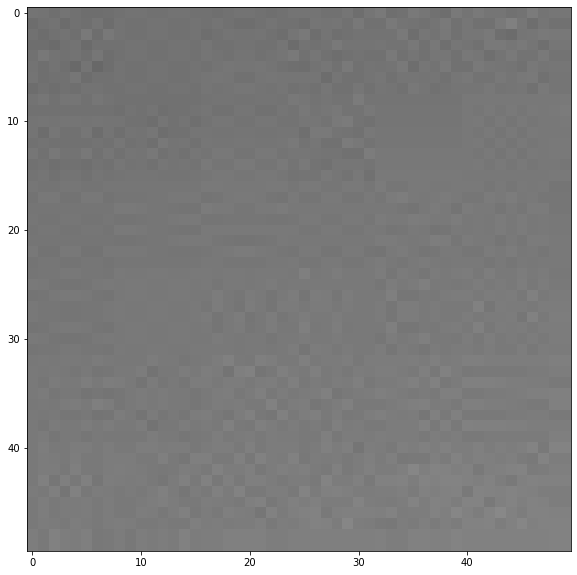

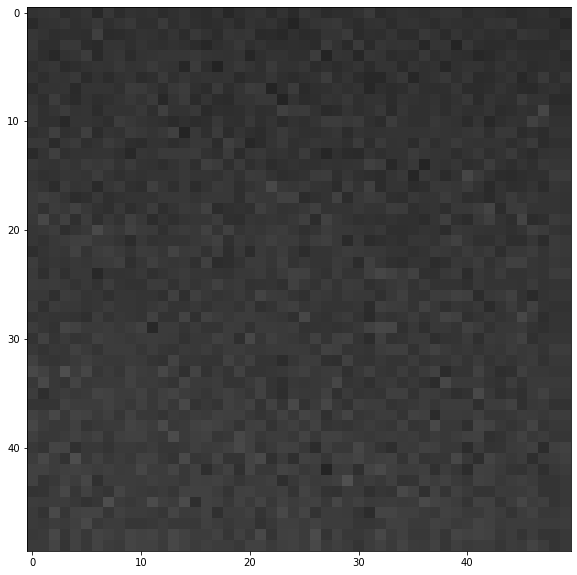

In [6]:
particle_radial_distance_threshold = 20
particle_maximum_interdistance = 10

predicted_positions_DT = benchmark.get_predicted_positions_DT(particle_radial_distance_threshold,
    particle_maximum_interdistance,
    number_frames_to_be_tracked,
    predicted_positions_wrt_frame)


nr_real_particles,nr_predictions,nr_TP,nr_FP,TP,FP_DT,links_DT,MAE,MSE = benchmark.hits_and_misses(number_frames_to_be_tracked,
                                                                  predicted_positions_DT,
                                                                  particle_positions_and_radiuses,
                                                                  long_return = True)

print(MAE)
print(MSE)
benchmark.visualize_hits_and_misses(number_frames_to_be_tracked,
                          frames, 
                          particle_positions_and_radiuses,
                          predicted_positions_DT,
                          FP_DT,
                          links_DT)

## Predict using our version

1.3825054886841095
4.029591552785485


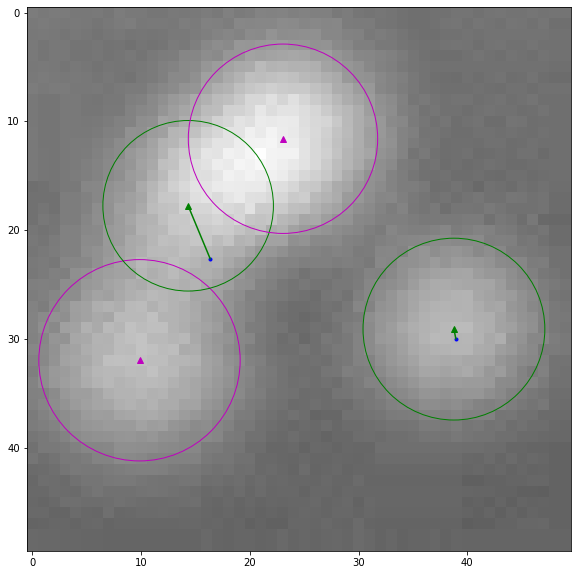

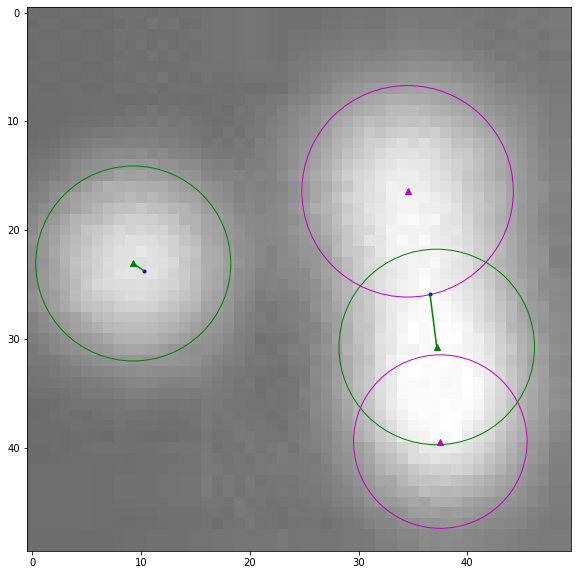

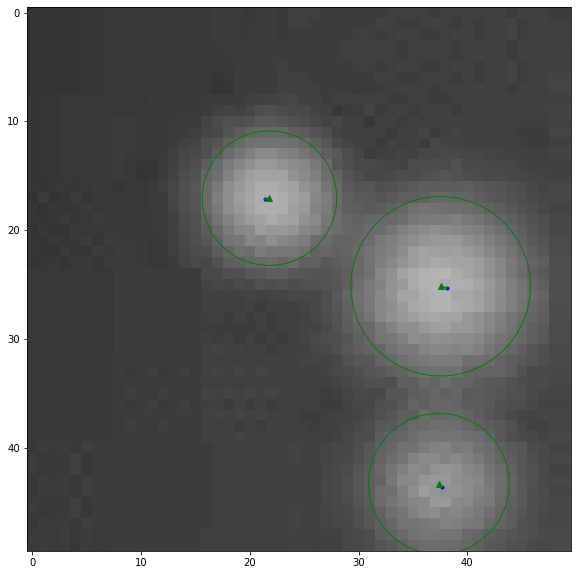

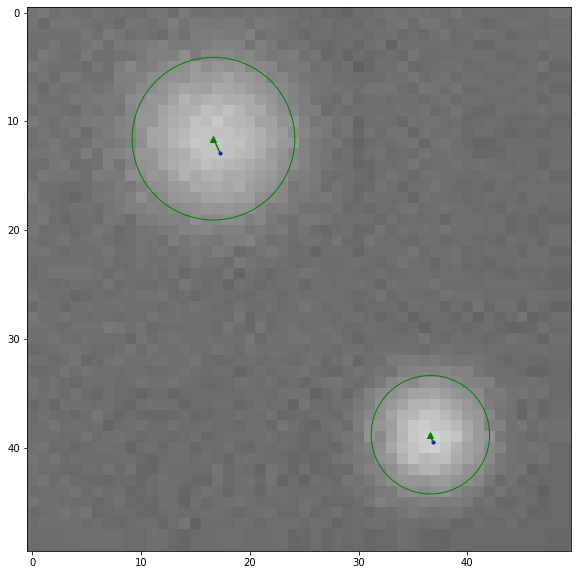

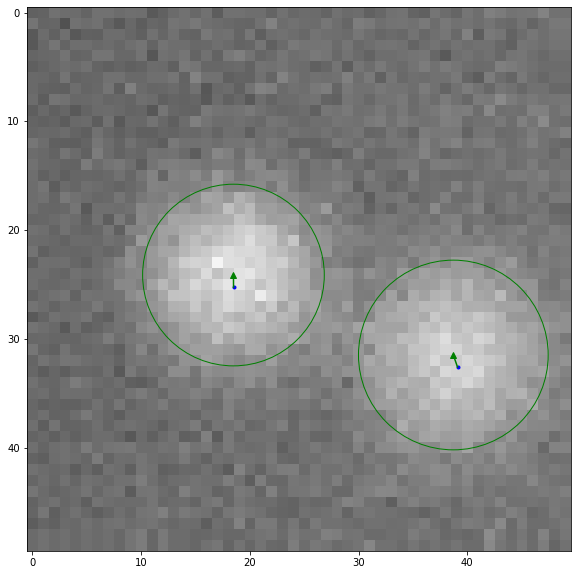

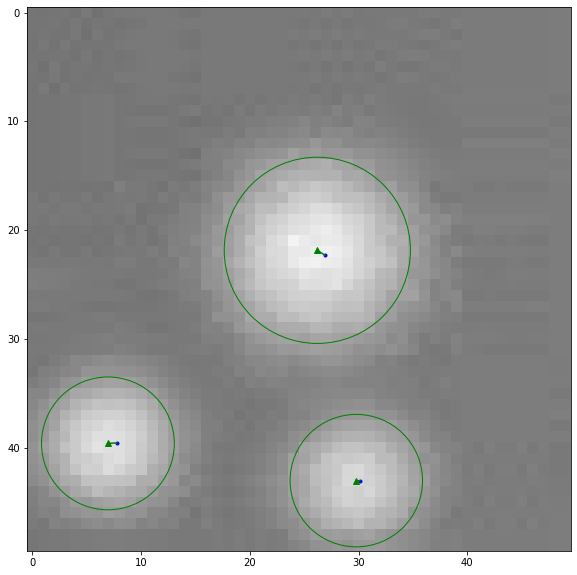

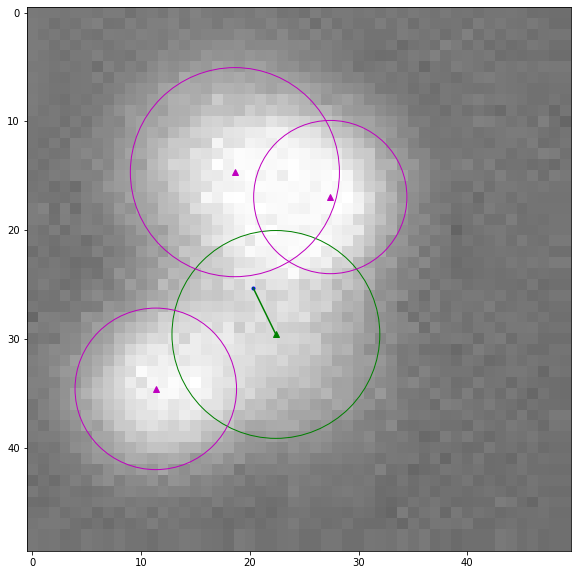

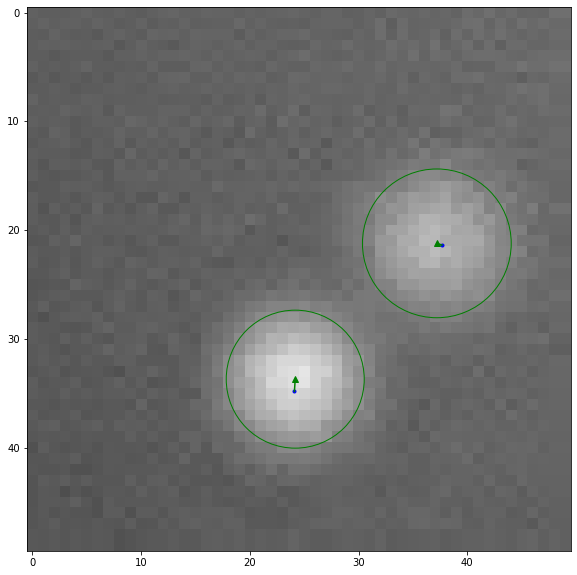

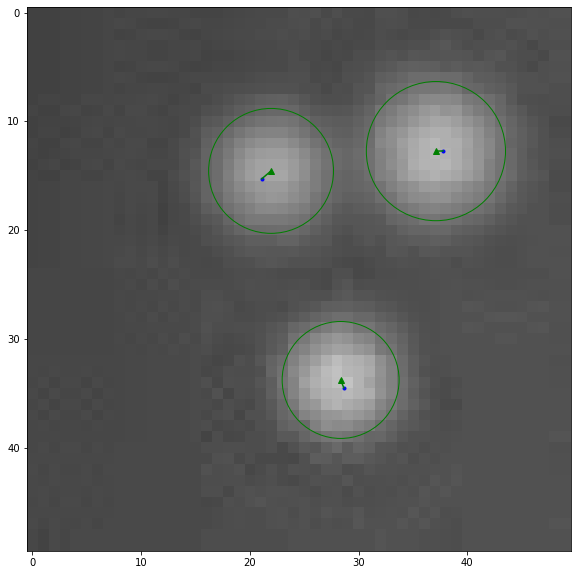

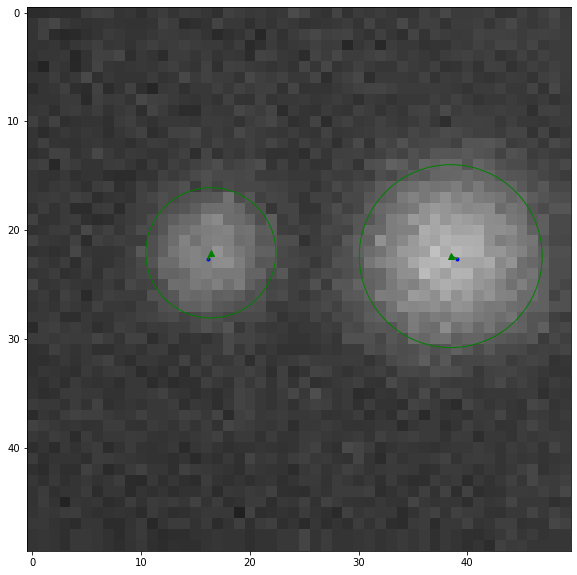

In [15]:

video = cv2.VideoCapture("output.mp4")
number_frames_to_be_tracked = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

batch_images = np.zeros((number_frames_to_be_tracked,video_height,video_width,1))


for i in range(number_frames_to_be_tracked):
    (ret, frame) = video.read()
    batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")
batch_predictions = unet.predict(model,batch_images)

batch = (unet.get_padded_images(batch_images),batch_labels,batch_predictions)


predicted_positions_unet = benchmark.get_predicted_positions_unet(number_frames_to_be_tracked, batch_predictions,video_width, video_height)


nr_real_particles,nr_predictions,nr_TP,nr_FP,TP,FP_unet,links_unet,MAE,MSE = benchmark.hits_and_misses(number_frames_to_be_tracked,
                                                                  predicted_positions_unet,
                                                                  particle_positions_and_radiuses,
                                                                  long_return = True)

print(MAE)
print(MSE)
benchmark.visualize_hits_and_misses(number_frames_to_be_tracked,
                          frames, 
                          particle_positions_and_radiuses,
                          predicted_positions_unet,
                          FP_unet,
                          links_unet)


## Predictions side by side

## MAE and MSE as function of SNR

In [5]:
def image_parameters_function(lower_limit_SNR, higher_limit_SNR, image_size = 256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    #particle_number = randint(1, 3)
    particle_number = 1
    particle_radius_list = uniform(1, 3, particle_number)
    (particle_center_x_list, particle_center_y_list) = IG.generate_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.05, 0.13, 1), ])

    image_parameters = IG.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.3, .5),
        signal_to_noise_ratio=lambda: uniform(lower_limit_SNR, higher_limit_SNR),
        gradient_intensity=lambda: uniform(0, 0),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

Iteration: 0, SNR: 5
Time taken for deeptrack prediction 0 : 19.928160190582275 sec
Time taken for unet prediction 0 : 0.41660237312316895 sec
Time taken for iteration 0 : 21.327935695648193 sec


Iteration: 1, SNR: 10
Time taken for deeptrack prediction 1 : 21.475295305252075 sec
Time taken for unet prediction 1 : 0.14510130882263184 sec
Time taken for iteration 1 : 22.61431360244751 sec


Iteration: 2, SNR: 15
Time taken for deeptrack prediction 2 : 20.911528825759888 sec
Time taken for unet prediction 2 : 0.11871838569641113 sec
Time taken for iteration 2 : 22.01022434234619 sec


Iteration: 3, SNR: 20
Time taken for deeptrack prediction 3 : 25.669284343719482 sec
Time taken for unet prediction 3 : 0.09635519981384277 sec
Time taken for iteration 3 : 27.19723081588745 sec


Iteration: 4, SNR: 25
Time taken for deeptrack prediction 4 : 26.66639518737793 sec
Time taken for unet prediction 4 : 0.08577084541320801 sec
Time taken for iteration 4 : 28.08613085746765 sec


Iteration: 5, SN

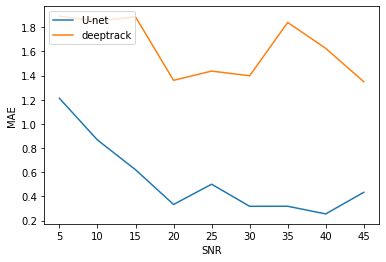

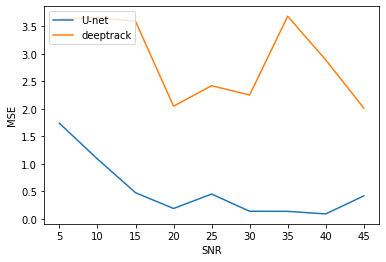

In [17]:
from numpy import zeros
import matplotlib.pyplot as plt
import os
import glob
import time

number_of_images_to_save = 30
model = unet.create_unet(pretrained_weights = "unet_particle.hdf5")

particle_radial_distance_threshold = 10
particle_maximum_interdistance = 8


SNRs = range(5,50,5)
unet_MAE = zeros(len(SNRs))
unet_MSE = zeros(len(SNRs))
DT_MAE = zeros(len(SNRs))
DT_MSE = zeros(len(SNRs))

files = glob.glob('./images/*')
for f in files:
    os.remove(f)


verbose = True

for itt,lower_SNR in enumerate(SNRs,0):
    if(verbose):
        print("Iteration: {}, SNR: {}".format(itt, lower_SNR))
        t = time.time()
    
    get_image_parameters_function=lambda: image_parameters_function(lower_SNR,lower_SNR + 5,image_size = 51)

    batch_images,batch_labels,batch_predictions, particle_positions_and_radiuses = IG.get_batch(get_image_parameters_function = get_image_parameters_function,
                                                                                                batch_size=number_of_images_to_save,
                                                                                                include_particle_positions_radii_and_intensities = True,
                                                                                                verbose = False) 
    
    
    
    
        
    for image_number,image in enumerate(batch_images):
        if image_number>=number_of_images_to_save:
            break
        else:
            filepath = './images/frame{}.jpg'.format(str(image_number))
            image = image*255
            cv2.imwrite(filepath,image)

    cv2.destroyAllWindows()
    
    benchmark.construct_video_from_images()
    
    saved_network_file_name = "DeepTrack - Example 3 - Pretrained network.h5"
    dt_model = DT.load(saved_network_file_name)

    video = cv2.VideoCapture("output.mp4")
    
    if(verbose):
        t1 = time.time()
        
        
        
    (number_frames_to_be_tracked, frames, predicted_positions_wrt_frame, predicted_positions_wrt_box, 
        boxes_all) = DT.track_video("output.mp4",
                                    dt_model,box_half_size = 8,box_scanning_step = 2,
                                    frame_normalize = 0,frame_enhance = 1,
                                    number_frames_to_be_tracked = 0)
    
    

    predicted_positions_DT = benchmark.get_predicted_positions_DT(particle_radial_distance_threshold,
        particle_maximum_interdistance,
        number_frames_to_be_tracked,
        predicted_positions_wrt_frame)

    if(verbose):
        time_taken = time.time() - t1
        print("Time taken for deeptrack prediction {} : {} sec".format(itt,time_taken))
        
    nr_real_particles,nr_predictions,nr_TP,nr_FP,TP,FP_DT,links_DT,MAE,MSE = benchmark.hits_and_misses(number_frames_to_be_tracked,
                                                                      predicted_positions_DT,
                                                                      particle_positions_and_radiuses,
                                                                      long_return = True)

    DT_MAE[itt] = MAE
    DT_MSE[itt] = MSE
    
    
    
    if(verbose):
        t2 = time.time()
        
        
    video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

    batch_images = np.zeros((number_frames_to_be_tracked,video_height,video_width,1))


    for i in range(number_frames_to_be_tracked):
        (ret, frame) = video.read()
        batch_images[i,:,:,0] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/255

    
    batch_predictions_unet = unet.predict(model,batch_images)

    predicted_positions_unet = benchmark.get_predicted_positions_unet(number_frames_to_be_tracked,
                                                                      batch_predictions_unet,
                                                                      video_width,
                                                                      video_height)
    
    
    if(verbose):
        time_taken = time.time() - t2
        print("Time taken for unet prediction {} : {} sec".format(itt,time_taken))

    nr_real_particles,nr_predictions,nr_TP,nr_FP,TP,FP_unet,links_unet,MAE,MSE = benchmark.hits_and_misses(number_frames_to_be_tracked,
                                                                      predicted_positions_unet,
                                                                      particle_positions_and_radiuses,
                                                                      long_return = True)

    unet_MAE[itt] = MAE
    unet_MSE[itt] = MSE
    
    if(verbose):
        time_taken = time.time() - t
        print("Time taken for iteration {} : {} sec".format(itt,time_taken))
        print()
        print()


plt.plot(SNRs,unet_MAE,label = "U-net")
plt.plot(SNRs,DT_MAE, label = "deeptrack")
plt.legend(loc="upper left")
plt.xlabel("SNR")
plt.ylabel("MAE")
plt.show()

plt.plot(SNRs,unet_MSE,label = "U-net")
plt.plot(SNRs,DT_MSE, label = "deeptrack")
plt.legend(loc="upper left")
plt.xlabel("SNR")
plt.ylabel("MSE")
plt.show()